In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

In [3]:
# Load in metadata
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
# Rename category "Cocktail dress / Party dress" to "Cocktail dress" to avoid problems in path definitions
meta['category'] = meta['category'].replace('Cocktail dress / Party dress', 'Cocktail dress')
# Rename "3/4 length" to "34 length" to avoid problems in path definitions
meta['sleeve_length'] = meta['sleeve_length'].replace('3/4 length', '34 length')

### Helper Functions

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

In [6]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [7]:
def generate_pti(latent, G_PTI):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    img = tensor2im(gen.squeeze(0))
    return img

In [8]:
def get_interpolations_multiple(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)


    for dim in dims_to_change:
        boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}.npy")
        boundary = torch.tensor(boundary)
        for i in range(steps):
            latent_code[i, dim, :] = latent_code[i, dim, :] + linspace[i] * boundary
    
    return latent_code

In [9]:
# def get_interpolations_multiple_projected(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir):
#     # Repeat Latent for num_steps
#     latent_code = latent_code.repeat(steps, 1, 1)


#     for dim in dims_to_change:
#         linspace = np.linspace(start_distance, end_distance, steps)
#         linspace = torch.tensor(linspace, dtype=torch.float32)
#         boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}.npy")
#         boundary = torch.tensor(boundary)

#         projection = latent_code[0, dim, :].reshape(1,-1).matmul(boundary.T)
#         linspace = linspace - np.array(projection)
#         for i in range(steps):
#             latent_code[i, dim, :] = latent_code[i, dim, :] + linspace[0, i] * boundary
    
#     return latent_code

### Interpolations with projection

In [10]:
# Define target attribute
attribute = 'category'
att1 = 'Day dress'
att2 = 'Occasion wear'

In [11]:
def run_example(attribute, att1, att2, steps=5, distance=15, dims_to_change=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):

    try:
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"

        # Load in Metadata
        df = pd.read_csv(f"{input_base_dir}metadata.csv")
    except:
        att1, att2 = att2, att1
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"

        # Load in Metadata
        df = pd.read_csv(f"{input_base_dir}metadata.csv")

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Sample one latent
    sample = df.sample(1)
    latent_code = latents[sample.sku.item()]

    # Generate Interpolations
    if sample.label.item() == 0: 
        start_distance, end_distance = 0, distance
    elif sample.label.item() == 1: 
        start_distance, end_distance = -distance,  0

    interpolations = get_interpolations_multiple(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir)

    imgs = [generate_from_latent(interpolations[i, :, :].unsqueeze(0)) for i in range(steps)]
    fig, ax = plt.subplots(1, steps, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
        ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")

    fig.suptitle(f"SKU: {sample.sku.item()}\nClass:{sample[attribute].item()} \n{att1} <-> {att2}")
    plt.show()

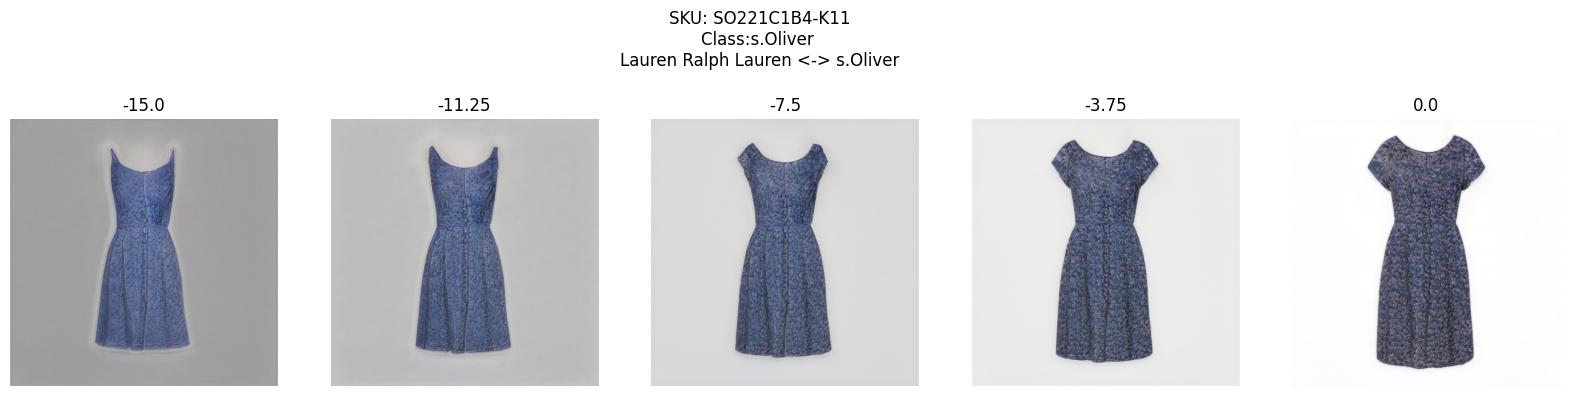

In [12]:
attribute = 'brand'
att1 = 's.Oliver'
att2 = 'Lauren Ralph Lauren'

run_example(attribute, att1, att2)

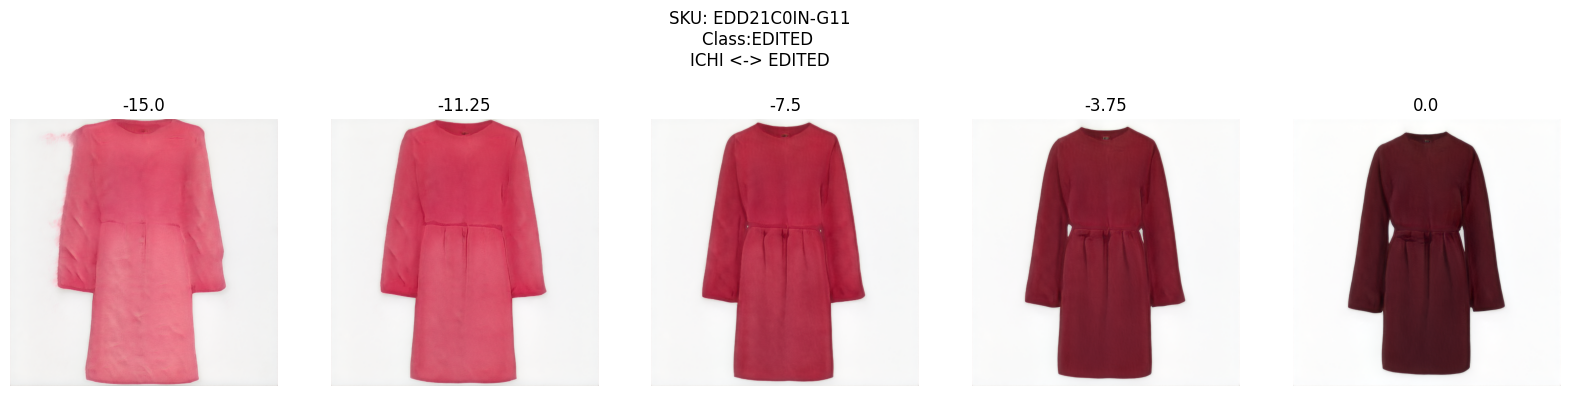

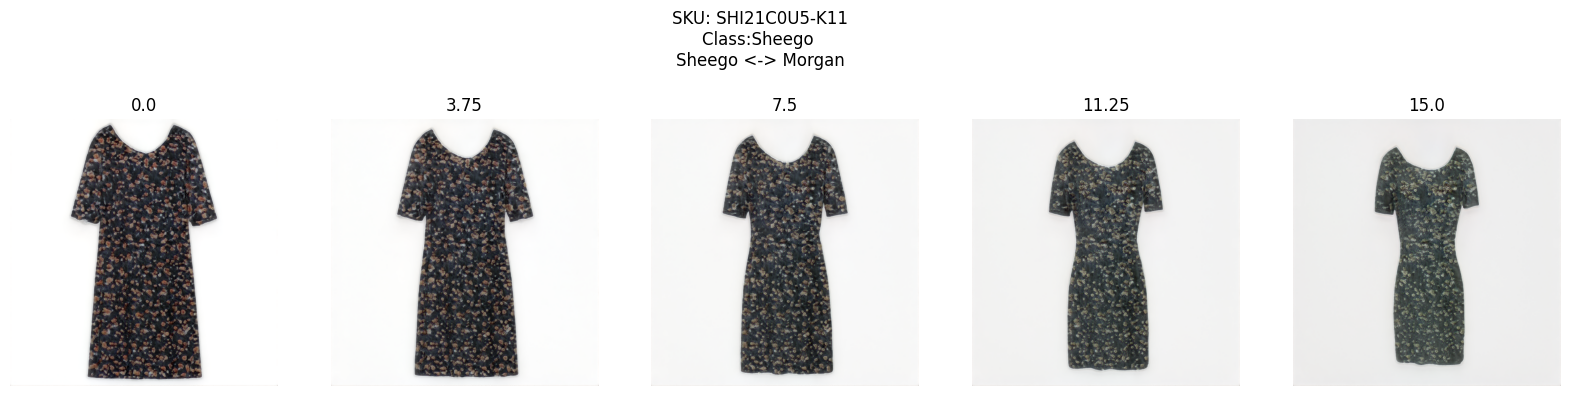

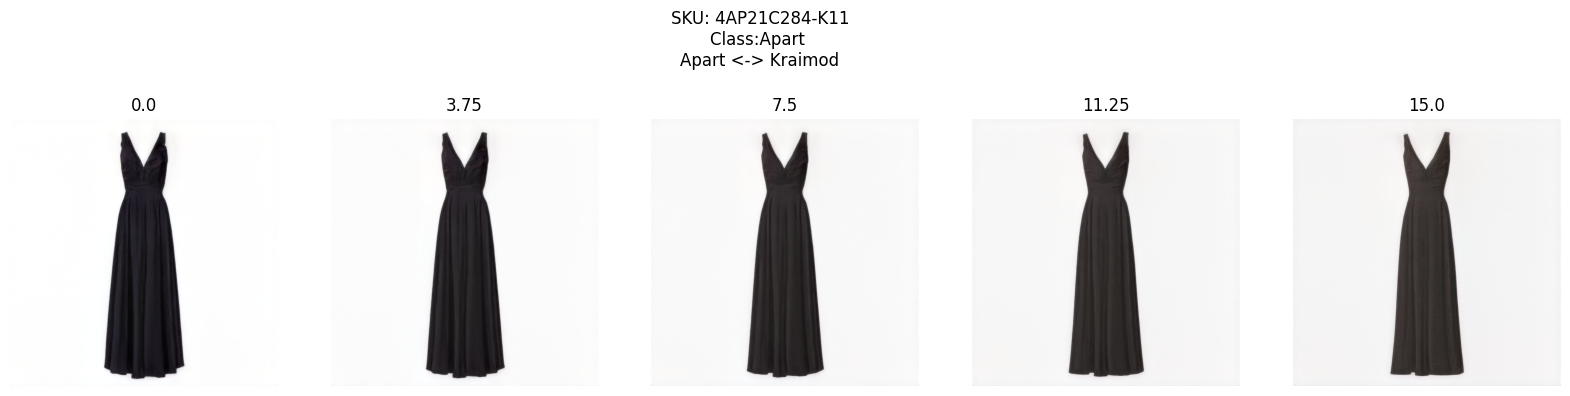

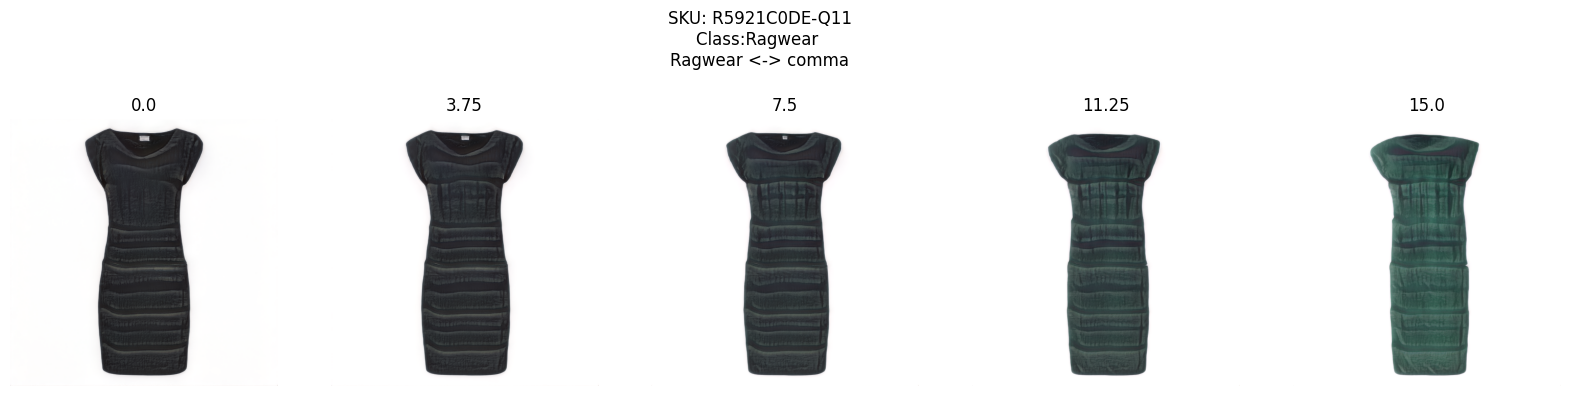

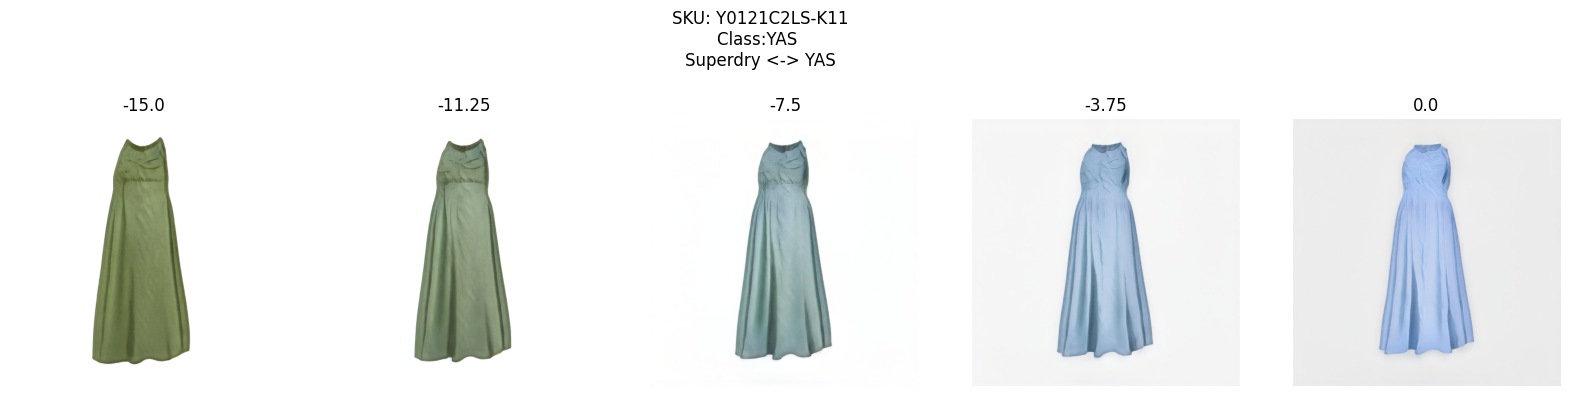

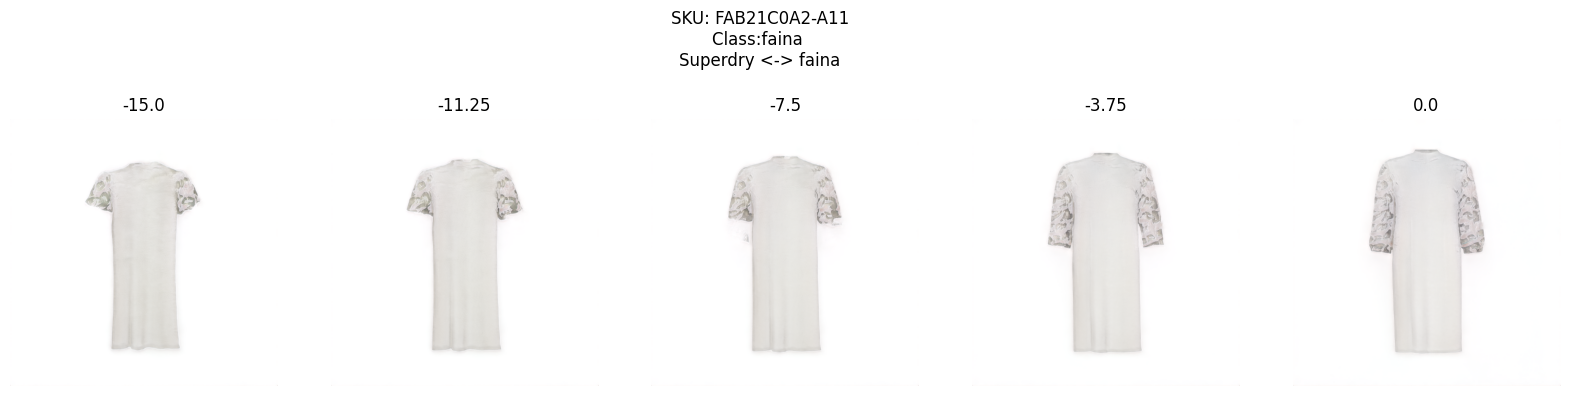

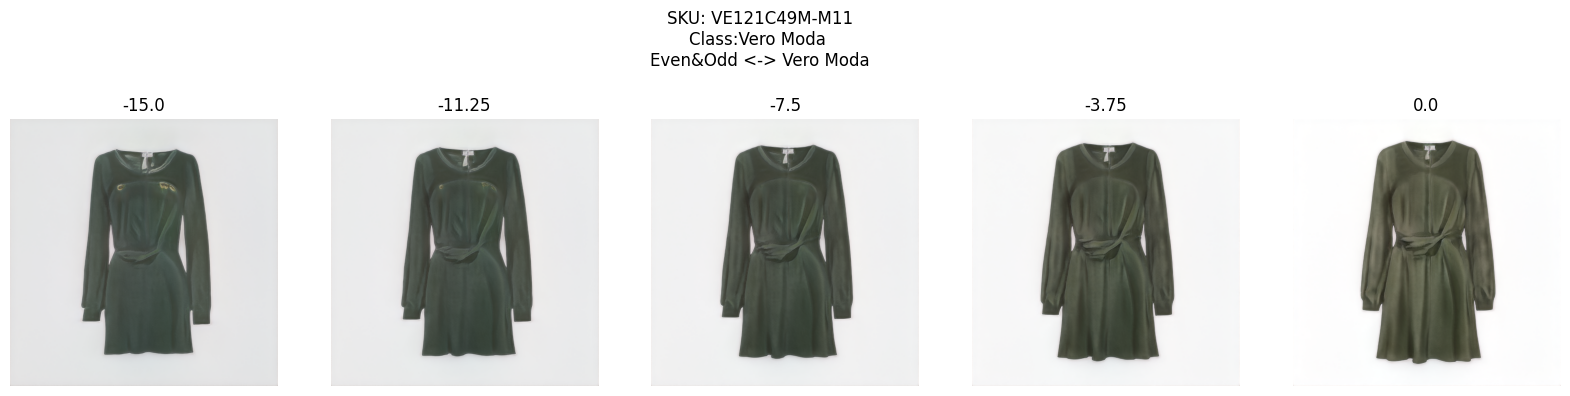

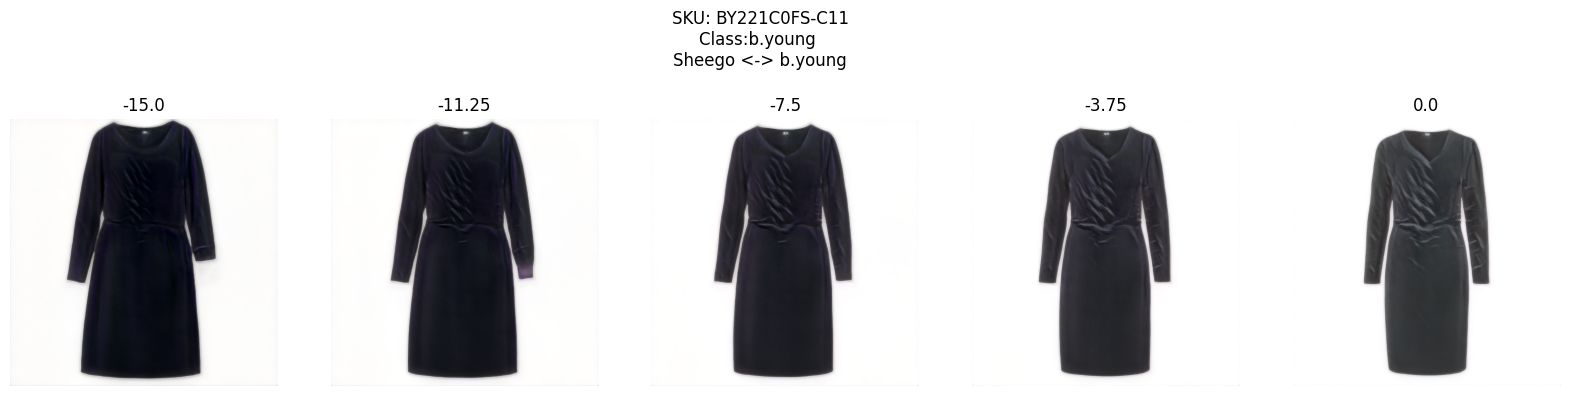

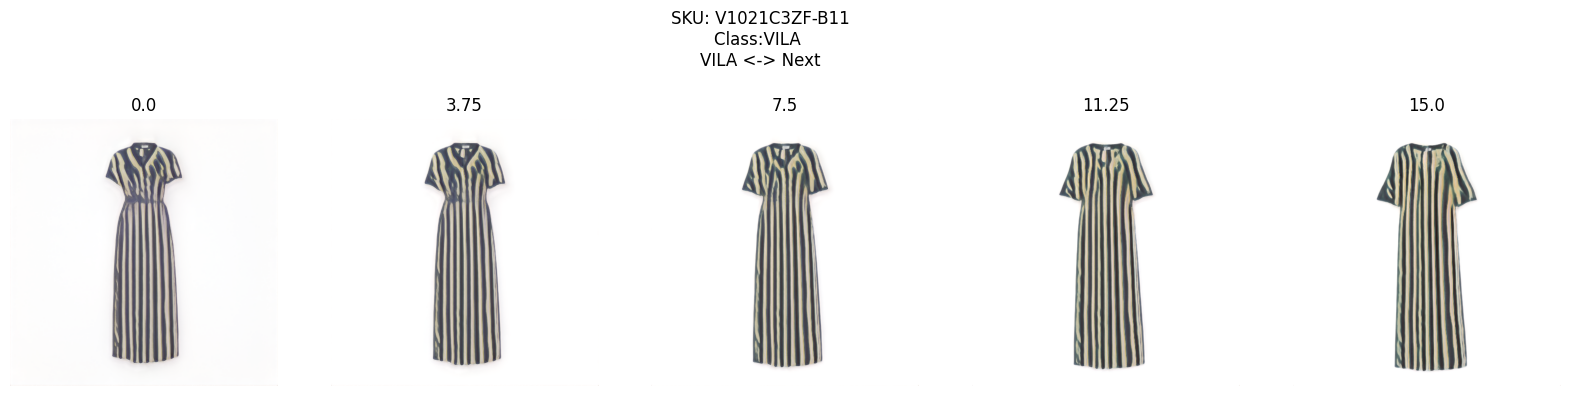

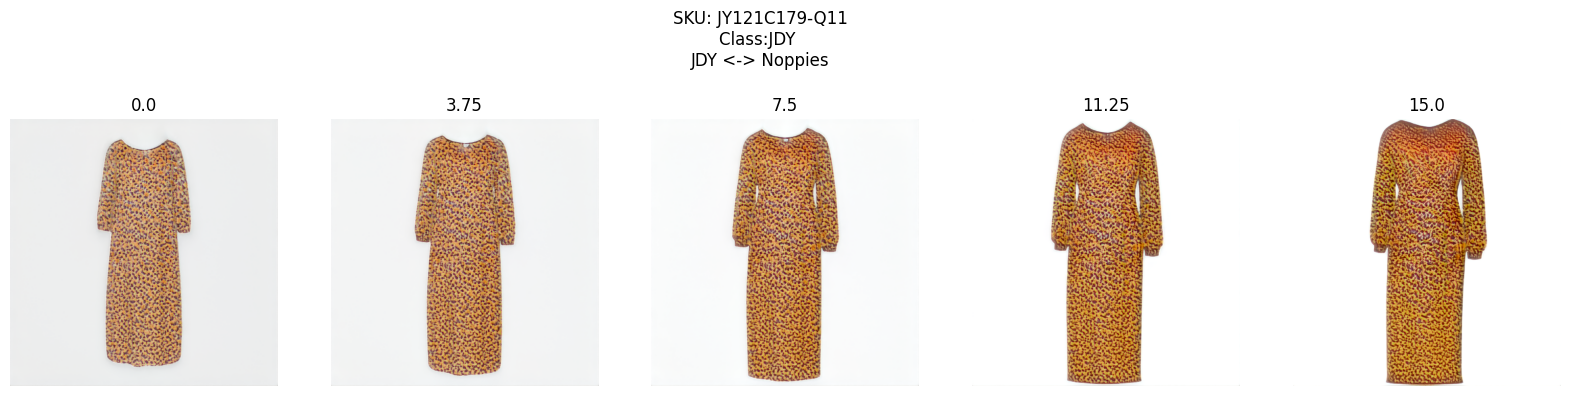

In [13]:
for i in range(10):
    counts = meta.brand.value_counts().sort_values(ascending=False)
    subset_brands = list(counts[counts > 80].index)
    sample = np.random.choice(subset_brands,2)
    attribute = 'brand'
    att1 = sample[0]
    att2 = sample[1]
    run_example(attribute, att1, att2)